In [1]:
from transformers import AutoTokenizer
from datasets import load_dataset

train_dataset = load_dataset("stanfordnlp/imdb", split="train")
test_dataset = load_dataset("stanfordnlp/imdb", split="test")

tokeniser = AutoTokenizer.from_pretrained('bert-base-uncased')



In [2]:
train_dataset[0]

{'text': 'I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and far be

In [3]:
def tokenise(batch):
    return tokeniser(batch["text"], padding="max_length", truncation=True, max_length=256)

train_dataset = train_dataset.map(tokenise, batched=True)
test_dataset = test_dataset.map(tokenise, batched=True)

train_dataset = train_dataset.remove_columns(["text"])
test_dataset = test_dataset.remove_columns(["text"])
train_dataset.set_format(type="torch", columns=["input_ids", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "label"])

In [4]:
from torch.utils.data import DataLoader
import torch 
import torch.nn as nn
import torch.nn.functional as F


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)


class CNN(nn.Module):
    def __init__(self, vocab_size, embed_dim=128, num_classes =2, kernel_sizes = [3,4,5], num_filters = 100, dropout = 0.5):
        super(CNN, self).__init__()
        self.embedding  = nn.Embedding(vocab_size, embed_dim)
        self.convs = nn.ModuleList([nn.Conv1d(embed_dim, num_filters, k) for k in kernel_sizes])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(num_filters * len(kernel_sizes), num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = x.permute(0,2,1)
        xs = [F.relu(conv(x)) for conv in self.convs]
        xs = [F.max_pool1d(x, x.shape[2]).squeeze(2) for x in xs]
        x = torch.cat(xs, dim=1)
        x = self.dropout(x)
        return self.fc(x)
        
    

In [12]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def train_and_eval(model, train_loader, test_loader, epochs=3, lr=0.0001):
    model.to(device)
    optimiser = optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            inputs, labels = batch["input_ids"].to(device), batch["label"].to(device)
            optimiser.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimiser.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}: train loss = {total_loss/len(train_loader):.4f}")

    # Evaluate
    model.eval()
    preds, trues = [], []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch["input_ids"].to(device), batch["label"].to(device)
            outputs = model(inputs)
            preds.extend(torch.argmax(outputs, dim=1).cpu().tolist())
            trues.extend(labels.cpu().tolist())

    acc = accuracy_score(trues, preds)
    return acc



Running config: {'embed_dim': 64, 'kernel_sizes': [3, 4, 5], 'num_filters': 100, 'dropout': 0.5}


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [00:55<00:00,  7.10it/s]


Epoch 1: train loss = 0.8368


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [00:53<00:00,  7.30it/s]


Epoch 2: train loss = 0.7536


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [01:12<00:00,  5.40it/s]


Epoch 3: train loss = 0.6893


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [01:14<00:00,  5.23it/s]


Epoch 4: train loss = 0.6465


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [00:56<00:00,  6.95it/s]


Epoch 5: train loss = 0.6170

Running config: {'embed_dim': 128, 'kernel_sizes': [3, 5, 7], 'num_filters': 100, 'dropout': 0.5}


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [01:31<00:00,  4.26it/s]


Epoch 1: train loss = 0.8218


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [02:04<00:00,  3.14it/s]


Epoch 2: train loss = 0.7021


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [01:48<00:00,  3.60it/s]


Epoch 3: train loss = 0.6319


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [01:33<00:00,  4.19it/s]


Epoch 4: train loss = 0.5774


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [01:52<00:00,  3.47it/s]


Epoch 5: train loss = 0.5427

Running config: {'embed_dim': 128, 'kernel_sizes': [3, 4, 5], 'num_filters': 200, 'dropout': 0.3}


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [02:18<00:00,  2.83it/s]


Epoch 1: train loss = 0.7127


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [02:51<00:00,  2.28it/s]


Epoch 2: train loss = 0.5837


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [03:03<00:00,  2.13it/s]


Epoch 3: train loss = 0.5065


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [03:05<00:00,  2.10it/s]


Epoch 4: train loss = 0.4580


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [03:17<00:00,  1.98it/s]


Epoch 5: train loss = 0.4180

Running config: {'embed_dim': 256, 'kernel_sizes': [2, 3, 4, 5], 'num_filters': 128, 'dropout': 0.5}


Epoch 1: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [04:12<00:00,  1.55it/s]


Epoch 1: train loss = 0.7525


Epoch 2: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [05:38<00:00,  1.16it/s]


Epoch 2: train loss = 0.5923


Epoch 3: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [05:34<00:00,  1.17it/s]


Epoch 3: train loss = 0.5190


Epoch 4: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [05:38<00:00,  1.15it/s]


Epoch 4: train loss = 0.4686


Epoch 5: 100%|███████████████████████████████████████████████████████████████████████| 391/391 [05:41<00:00,  1.15it/s]


Epoch 5: train loss = 0.4319


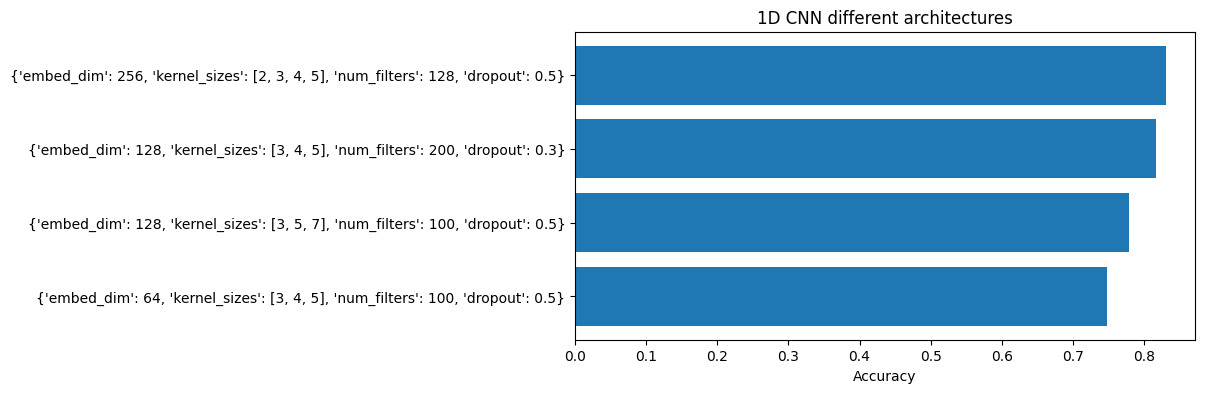

In [13]:
import matplotlib.pyplot as plt

experiments = [
    {"embed_dim": 64, "kernel_sizes": [3,4,5], "num_filters": 100, "dropout": 0.5},
    {"embed_dim": 128, "kernel_sizes": [3,5,7], "num_filters": 100, "dropout": 0.5},
    {"embed_dim": 128, "kernel_sizes": [3,4,5], "num_filters": 200, "dropout": 0.3},
    {"embed_dim": 256, "kernel_sizes": [2,3,4,5], "num_filters": 128, "dropout": 0.5},
]

results = []

for config in experiments:
    print(f"\nRunning config: {config}")
    model = CNN(
        vocab_size=tokeniser.vocab_size,
        embed_dim=config["embed_dim"],
        kernel_sizes=config["kernel_sizes"],
        num_filters=config["num_filters"],
        dropout=config["dropout"]
    )
    acc = train_and_eval(model, train_loader, test_loader, epochs=5)
    results.append((str(config), acc))

labels, accs = zip(*results)
plt.figure(figsize=(8,4))
plt.barh(labels, accs)
plt.xlabel("Accuracy")
plt.title("1D CNN different architectures")
plt.show()
